# Lambda School Data Science Unit 4 Sprint Challenge 4

## RNNs, CNNs, AutoML, and more...

In this sprint challenge, you'll explore some of the cutting edge of Data Science.

*Caution* - these approaches can be pretty heavy computationally. All problems were designed so that you should be able to achieve results within at most 5-10 minutes of runtime on Colab or a comparable environment. If something is running longer, doublecheck your approach!

## Part 1 - RNNs

Use an RNN to fit a simple classification model on tweets to distinguish from tweets from Austen Allred and tweets from Weird Al Yankovic.

Following is code to scrape the needed data (no API auth needed, uses [twitterscraper](https://github.com/taspinar/twitterscraper)):

In [20]:
!pip install twitterscraper

  Stored in directory: /root/.cache/pip/wheels/45/50/9b/70128bca07e2bf8b5ed3f504002e9e74a6eaa5e756341b6931
Successfully built twitterscraper


In [21]:
from twitterscraper import query_tweets

austen_tweets = query_tweets('from:austen', 1000)
len(austen_tweets)

INFO: queries: ['from:austen since:2006-03-21 until:2006-11-14', 'from:austen since:2006-11-14 until:2007-07-11', 'from:austen since:2007-07-11 until:2008-03-05', 'from:austen since:2008-03-05 until:2008-10-30', 'from:austen since:2008-10-30 until:2009-06-25', 'from:austen since:2009-06-25 until:2010-02-19', 'from:austen since:2010-02-19 until:2010-10-15', 'from:austen since:2010-10-15 until:2011-06-11', 'from:austen since:2011-06-11 until:2012-02-04', 'from:austen since:2012-02-04 until:2012-09-30', 'from:austen since:2012-09-30 until:2013-05-26', 'from:austen since:2013-05-26 until:2014-01-20', 'from:austen since:2014-01-20 until:2014-09-15', 'from:austen since:2014-09-15 until:2015-05-12', 'from:austen since:2015-05-12 until:2016-01-05', 'from:austen since:2016-01-05 until:2016-08-31', 'from:austen since:2016-08-31 until:2017-04-26', 'from:austen since:2017-04-26 until:2017-12-21', 'from:austen since:2017-12-21 until:2018-08-16', 'from:austen since:2018-08-16 until:2019-04-12']
INFO

181

In [22]:
austen_tweets[0].text

'I love love love working with great people.pic.twitter.com/fCKOm6Vl'

In [23]:
al_tweets = query_tweets('from:AlYankovic', 1000)
len(al_tweets)

INFO: queries: ['from:AlYankovic since:2006-03-21 until:2006-11-14', 'from:AlYankovic since:2006-11-14 until:2007-07-11', 'from:AlYankovic since:2007-07-11 until:2008-03-05', 'from:AlYankovic since:2008-03-05 until:2008-10-30', 'from:AlYankovic since:2008-10-30 until:2009-06-25', 'from:AlYankovic since:2009-06-25 until:2010-02-19', 'from:AlYankovic since:2010-02-19 until:2010-10-15', 'from:AlYankovic since:2010-10-15 until:2011-06-11', 'from:AlYankovic since:2011-06-11 until:2012-02-04', 'from:AlYankovic since:2012-02-04 until:2012-09-30', 'from:AlYankovic since:2012-09-30 until:2013-05-26', 'from:AlYankovic since:2013-05-26 until:2014-01-20', 'from:AlYankovic since:2014-01-20 until:2014-09-15', 'from:AlYankovic since:2014-09-15 until:2015-05-12', 'from:AlYankovic since:2015-05-12 until:2016-01-05', 'from:AlYankovic since:2016-01-05 until:2016-08-31', 'from:AlYankovic since:2016-08-31 until:2017-04-26', 'from:AlYankovic since:2017-04-26 until:2017-12-21', 'from:AlYankovic since:2017-12

960

In [24]:
al_tweets[0].text

'RT @GeoffTheRobot: Hey Al, you played zydeco on my ribs at the RED premiere and it airs tonight on Late Late with @CraigyFerg!'

In [25]:
len(austen_tweets + al_tweets)

1141

Your tasks:

- Encode the characters to a sequence of integers for the model
- Get the data into the appropriate shape/format, including labels and a train/test split
- Use Keras to fit a predictive model, classifying tweets as being from Austen versus Weird Al
- Report your overall score and accuracy

For reference, the [Keras IMDB sentiment classification example](https://github.com/keras-team/keras/blob/master/examples/imdb_lstm.py) will be useful, as well the RNN code we used in class.

*Note* - focus on getting a running model, not on maxing accuracy with extreme data size or epoch numbers. Only revisit and push accuracy if you get everything else done!

In [0]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
import numpy as np
import pandas as pd

In [27]:
austen_text = ''

for tweet in austen_tweets:
    austen_text += '\n\n' + tweet.text
  
austen_text = austen_text.split('\n\n')
austen_list = [item for sublist in austen_text for item in sublist]
print(austen_list)

['I', ' ', 'l', 'o', 'v', 'e', ' ', 'l', 'o', 'v', 'e', ' ', 'l', 'o', 'v', 'e', ' ', 'w', 'o', 'r', 'k', 'i', 'n', 'g', ' ', 'w', 'i', 't', 'h', ' ', 'g', 'r', 'e', 'a', 't', ' ', 'p', 'e', 'o', 'p', 'l', 'e', '.', 'p', 'i', 'c', '.', 't', 'w', 'i', 't', 't', 'e', 'r', '.', 'c', 'o', 'm', '/', 'f', 'C', 'K', 'O', 'm', '6', 'V', 'l', 'E', 'l', 'o', 'n', ' ', 'M', 'u', 's', 'k', ' ', 'i', 's', ' ', 's', 'e', 'v', 'e', 'r', 'e', 'l', 'y', ' ', 'u', 'n', 'd', 'e', 'r', 'r', 'a', 't', 'e', 'd', 'S', 'p', 'a', 'c', 'e', 'X', ' ', '2', '0', '0', '2', ' ', 'v', 's', ' ', '2', '0', '1', '7', 'p', 'i', 'c', '.', 't', 'w', 'i', 't', 't', 'e', 'r', '.', 'c', 'o', 'm', '/', 'd', 't', 'z', 'B', 'I', 'D', '2', 'Q', '3', 'v', 'Y', 'e', 's', '.', ' ', 'O', 'n', ' ', 't', 'h', 'e', ' ', 'b', 'l', 'o', 'c', 'k', 'c', 'h', 'a', 'i', 'n', '.', 'T', 'h', 'i', 's', ' ', 'i', 's', ' ', 'a', ' ', 'p', 'u', 'b', 'l', 'i', 'c', 'l', 'y', ' ', 't', 'r', 'a', 'd', 'e', 'd', ' ', 'c', 'o', 'm', 'p', 'a', 'n', 'y',

In [28]:
al_text = ''

for tweet in al_tweets:
    al_text += '\n\n' + tweet.text
  
al_text = al_text.split('\n\n')
al_list = [item for sublist in al_text for item in sublist]
print(al_list)

['R', 'T', ' ', '@', 'G', 'e', 'o', 'f', 'f', 'T', 'h', 'e', 'R', 'o', 'b', 'o', 't', ':', ' ', 'H', 'e', 'y', ' ', 'A', 'l', ',', ' ', 'y', 'o', 'u', ' ', 'p', 'l', 'a', 'y', 'e', 'd', ' ', 'z', 'y', 'd', 'e', 'c', 'o', ' ', 'o', 'n', ' ', 'm', 'y', ' ', 'r', 'i', 'b', 's', ' ', 'a', 't', ' ', 't', 'h', 'e', ' ', 'R', 'E', 'D', ' ', 'p', 'r', 'e', 'm', 'i', 'e', 'r', 'e', ' ', 'a', 'n', 'd', ' ', 'i', 't', ' ', 'a', 'i', 'r', 's', ' ', 't', 'o', 'n', 'i', 'g', 'h', 't', ' ', 'o', 'n', ' ', 'L', 'a', 't', 'e', ' ', 'L', 'a', 't', 'e', ' ', 'w', 'i', 't', 'h', ' ', '@', 'C', 'r', 'a', 'i', 'g', 'y', 'F', 'e', 'r', 'g', '!', 'W', 'o', 'w', ',', ' ', 'I', ' ', 'c', 'a', 'n', "'", 't', ' ', 'b', 'e', 'l', 'i', 'e', 'v', 'e', ' ', 'h', 'o', 'w', ' ', 'q', 'u', 'i', 'c', 'k', 'l', 'y', ' ', 't', 'h', 'e', 'y', ' ', 'w', 'e', 'r', 'e', ' ', 'a', 'b', 'l', 'e', ' ', 't', 'o', ' ', 'r', 'u', 's', 'h', ' ', 't', 'h', 'i', 's', ' ', 'M', 'e', 'l', ' ', 'G', 'i', 'b', 's', 'o', 'n', ' ', 'b', 'i',

In [30]:
aust_chars = list(set(austen_list)) # split and remove duplicate characters. convert to list.

aust_num_chars = len(aust_chars) # the number of unique characters
aust_data_size = len(austen_list)

print("unique characters : ", aust_num_chars)
print("txt_data_size : ", aust_data_size)

unique characters :  90
txt_data_size :  16087


In [31]:
# one hot encode
aust_char_to_int = dict((c, i) for i, c in enumerate(aust_chars)) # "enumerate" retruns index and value. Convert it to dictionary
aust_int_to_char = dict((i, c) for i, c in enumerate(aust_chars))
print(aust_char_to_int)
print("----------------------------------------------------")
print(aust_int_to_char)
print("----------------------------------------------------")
# integer encode input data
aust_integer_encoded = [aust_char_to_int[i] for i in austen_list] # "integer_encoded" is a list which has a sequence converted from an original data to integers.
print(aust_integer_encoded)
print("----------------------------------------------------")
print("data length : ", len(aust_integer_encoded))


{'7': 0, 'X': 1, "'": 2, ',': 3, 'T': 4, '!': 5, 'g': 6, ';': 7, 'ï': 8, 'r': 9, '1': 10, 'b': 11, 'n': 12, 'J': 13, 'h': 14, 'C': 15, 'F': 16, '@': 17, '(': 18, 'I': 19, 'S': 20, 't': 21, '"': 22, '’': 23, '/': 24, '*': 25, '_': 26, '6': 27, 's': 28, '8': 29, '?': 30, '5': 31, 'V': 32, 'e': 33, 'Z': 34, 'i': 35, 'c': 36, '9': 37, 'D': 38, 'Y': 39, 'M': 40, 'U': 41, '-': 42, 'H': 43, 'u': 44, 'A': 45, 'P': 46, 'p': 47, 'K': 48, '“': 49, 'L': 50, ' ': 51, 'd': 52, 'l': 53, 'o': 54, 'N': 55, 'W': 56, 'y': 57, '3': 58, 'z': 59, 'G': 60, '…': 61, 'v': 62, '2': 63, '.': 64, 'R': 65, '+': 66, 'Q': 67, '”': 68, 'a': 69, 'x': 70, 'f': 71, 'q': 72, '%': 73, ')': 74, 'E': 75, 'O': 76, 'm': 77, ':': 78, 'w': 79, '\xa0': 80, 'B': 81, '4': 82, 'k': 83, '0': 84, '#': 85, '$': 86, '&': 87, 'j': 88, '\n': 89}
----------------------------------------------------
{0: '7', 1: 'X', 2: "'", 3: ',', 4: 'T', 5: '!', 6: 'g', 7: ';', 8: 'ï', 9: 'r', 10: '1', 11: 'b', 12: 'n', 13: 'J', 14: 'h', 15: 'C', 16: 'F'

In [0]:
aust_y = np.ones((aust_data_size,), dtype=int)

In [34]:
al_chars = list(set(al_list)) # split and remove duplicate characters. convert to list.

al_num_chars = len(al_chars) # the number of unique characters
al_data_size = len(al_list)

print("unique characters : ", al_num_chars)
print("txt_data_size : ", al_data_size)

unique characters :  104
txt_data_size :  94035


In [35]:
# one hot encode
al_char_to_int = dict((c, i) for i, c in enumerate(al_chars)) # "enumerate" retruns index and value. Convert it to dictionary
al_int_to_char = dict((i, c) for i, c in enumerate(al_chars))
print(al_char_to_int)
print("----------------------------------------------------")
print(al_int_to_char)
print("----------------------------------------------------")
# integer encode input data
al_integer_encoded = [al_char_to_int[i] for i in al_list] # "integer_encoded" is a list which has a sequence converted from an original data to integers.
print(al_integer_encoded)
print("----------------------------------------------------")
print("data length : ", len(al_integer_encoded))

{'7': 0, 'X': 1, 'т': 2, "'": 3, ',': 4, 'T': 5, '!': 6, 'g': 7, ';': 8, 'r': 9, '‘': 10, '1': 11, 'b': 12, 'n': 13, 'J': 14, 'h': 15, 'C': 16, 'F': 17, '@': 18, '(': 19, 'é': 20, 'I': 21, 'S': 22, 't': 23, 'З': 24, '"': 25, 'у': 26, '’': 27, '/': 28, '*': 29, 'д': 30, '_': 31, 's': 32, '6': 33, '8': 34, '?': 35, '5': 36, 'с': 37, 'V': 38, 'e': 39, 'Z': 40, 'i': 41, '–': 42, 'c': 43, 'р': 44, '9': 45, 'D': 46, 'Y': 47, 'M': 48, '-': 49, 'U': 50, 'í': 51, 'H': 52, 'u': 53, 'A': 54, 'P': 55, 'p': 56, '“': 57, 'K': 58, 'L': 59, ' ': 60, 'd': 61, 'l': 62, 'o': 63, 'N': 64, 'W': 65, 'y': 66, '3': 67, 'z': 68, 'G': 69, '…': 70, 'v': 71, '2': 72, '.': 73, '™': 74, 'R': 75, 'в': 76, 'Q': 77, '”': 78, 'a': 79, 'x': 80, 'f': 81, 'q': 82, '%': 83, ')': 84, 'E': 85, 'O': 86, 'm': 87, ':': 88, 'w': 89, '\xa0': 90, 'а': 91, 'B': 92, 'е': 93, 'й': 94, '4': 95, 'k': 96, '0': 97, '#': 98, '$': 99, '&': 100, 'j': 101, '—': 102, '\n': 103}
----------------------------------------------------
{0: '7', 1: 

In [0]:
al_y = np.zeros((al_data_size,), dtype=int)

In [60]:
from sklearn.model_selection import train_test_split

X = np.concatenate((aust_integer_encoded, al_integer_encoded), axis=None)
y = np.concatenate((aust_y, al_y), axis=None)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.75, test_size=0.25)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(82591,)
(82591,)
(27531,)
(27531,)


In [63]:
max_features = 10000
# cut texts after this number of chars (among top max_features most common chars)
batch_size = 32

model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=15,
          validation_data=(X_test, y_test))
score, acc = model.evaluate(X_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Train on 82591 samples, validate on 27531 samples
Epoch 1/15
82591/82591 [==============================] - 68s 820us/step - loss: 0.1851 - acc: 0.9262 - val_loss: 0.1730 - val_acc: 0.9299
Epoch 2/15
82591/82591 [==============================] - 42s 506us/step - loss: 0.1747 - acc: 0.9277 - val_loss: 0.1735 - val_acc: 0.9303
Epoch 3/15
82591/82591 [==============================] - 42s 506us/step - loss: 0.1742 - acc: 0.9279 - val_loss: 0.1727 - val_acc: 0.9308
Epoch 4/15
82591/82591 [==============================] - 41s 502us/step - loss: 0.1741 - acc: 0.9282 - val_loss: 0.1728 - val_acc: 0.9303
Epoch 5/15
82591/82591 [==============================] - 41s 502us/step - loss: 0.1738 - acc: 0.9283 - val_loss: 0.1718 - val_acc: 0.9308
Epoch 6/15
82591/82591 [==============================] - 41s 501us/step - loss: 0.1735 - acc: 0.9282 - val_loss: 0.1720 - val_acc: 0.9312
Epoch 7/15
82591/82591 [==============================] - 41s 499us/step - loss: 0.1736 - acc: 0.9284 - val_loss: 0.

Conclusion - RNN runs, and gives pretty decent improvement over a naive "It's Al!" model. To *really* improve the model, more playing with parameters, and just getting more data (particularly Austen tweets), would help. Also - RNN may well not be the best approach here, but it is at least a valid one.

## Part 2- CNNs

Time to play "find the frog!" Use Keras and ResNet50 to detect which of the following images contain frogs:

In [10]:
!pip install google_images_download

    100% |████████████████████████████████| 911kB 21.7MB/s 
  Stored in directory: /root/.cache/pip/wheels/d2/23/84/3cec6d566b88bef64ad727a7e805f6544b8af4a8f121f9691c
Successfully built google-images-download


In [11]:
from google_images_download import google_images_download

response = google_images_download.googleimagesdownload()
arguments = {"keywords": "animal pond", "limit": 5, "print_urls": True}
absolute_image_paths = response.download(arguments)


Item no.: 1 --> Item name = animal pond
Evaluating...
Starting Download...
Image URL: https://www.enchantedlearning.com/pgifs/Pondanimals.GIF
Completed Image ====> 1. pondanimals.gif
Image URL: https://i.ytimg.com/vi/NCbu0TND9vE/hqdefault.jpg
Completed Image ====> 2. hqdefault.jpg
Image URL: https://pklifescience.com/staticfiles/articles/images/PKLS4116_inline.png
Completed Image ====> 3. pkls4116_inline.png
Image URL: https://vetstreet-brightspot.s3.amazonaws.com/8d/ac/377fecad46d8820697c26efacc32/koi-pond-thinkstock-153560141-335sm61313.jpg
Completed Image ====> 4. koi-pond-thinkstock-153560141-335sm61313.jpg
Image URL: https://pixnio.com/free-images/fauna-animals/reptiles-and-amphibians/alligators-and-crocodiles-pictures/alligator-animal-on-pond.jpg
Completed Image ====> 5. alligator-animal-on-pond.jpg

Errors: 0



At time of writing at least a few do, but since the Internet changes - it is possible your 5 won't. You can easily verify yourself, and (once you have working code) increase the number of images you pull to be more sure of getting a frog. Your goal is to validly run ResNet50 on the input images - don't worry about tuning or improving the model.

*Hint* - ResNet 50 doesn't just return "frog". The three labels it has for frogs are: `bullfrog, tree frog, tailed frog`

*Stretch goal* - also check for fish.

In [12]:
absolute_image_paths

{'animal pond': ['/content/downloads/animal pond/1. pondanimals.gif',
  '/content/downloads/animal pond/2. hqdefault.jpg',
  '/content/downloads/animal pond/3. pkls4116_inline.png',
  '/content/downloads/animal pond/4. koi-pond-thinkstock-153560141-335sm61313.jpg',
  '/content/downloads/animal pond/5. alligator-animal-on-pond.jpg']}

In [0]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions

def process_img_path(img_path):
  return image.load_img(img_path, target_size=(224, 224))

def img_contains_frog(img):
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  model = ResNet50(weights='imagenet')
  features = model.predict(x)
  results = decode_predictions(features, top=3)[0]
  print(results)
  for entry in results:
    if entry[1] in ('bullfrog', 'tree frog', 'tailed frog'):
      return entry[2]
  return 0.0

def img_contains_fish(img):
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  model = ResNet50(weights='imagenet')
  features = model.predict(x)
  results = decode_predictions(features, top=3)[0]
  print(results)
  for entry in results:
    if entry[1] in ('goldfish', 'jellyfish', 'crayfish', 'anemone_fish',
                   'starfish','lionfish'):
      return entry[2]
  return 0.0

In [14]:
from IPython.display import Image
Image(filename='/content/downloads/animal pond/1. pondanimals.gif', width=600)

ValueError: ignored

In [16]:
import numpy as np
img_contains_frog(process_img_path('/content/downloads/animal pond/1. pondanimals.gif'))


Instructions for updating:
Colocations handled automatically by placer.
40960/35363 [==================================] - 0s 2us/step
[('n03598930', 'jigsaw_puzzle', 0.8680313), ('n06359193', 'web_site', 0.06410024), ('n02834397', 'bib', 0.021264324)]


0.0

In [44]:
img_contains_fish(process_img_path('/content/downloads/animal pond/1. pondanimals.gif'))

[('n03598930', 'jigsaw_puzzle', 0.8680313), ('n06359193', 'web_site', 0.06410024), ('n02834397', 'bib', 0.021264324)]


0.0

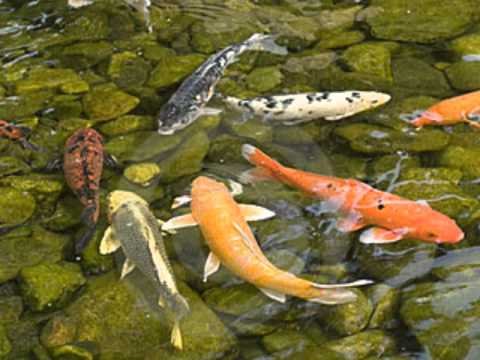

In [0]:
Image(filename='/Users/ksmith/Documents/Code/DS1/Unit4/DS-Unit-4-Sprint-4-Deep-Learning/downloads/animal pond/2. hqdefault.jpg', width=600)

In [45]:
img_contains_frog(process_img_path('/content/downloads/animal pond/2. hqdefault.jpg'))

[('n01443537', 'goldfish', 0.8495859), ('n01631663', 'eft', 0.06760218), ('n02536864', 'coho', 0.035163548)]


0.0

In [46]:
img_contains_fish(process_img_path('/content/downloads/animal pond/2. hqdefault.jpg'))

[('n01443537', 'goldfish', 0.8495859), ('n01631663', 'eft', 0.06760218), ('n02536864', 'coho', 0.035163548)]


0.8495859

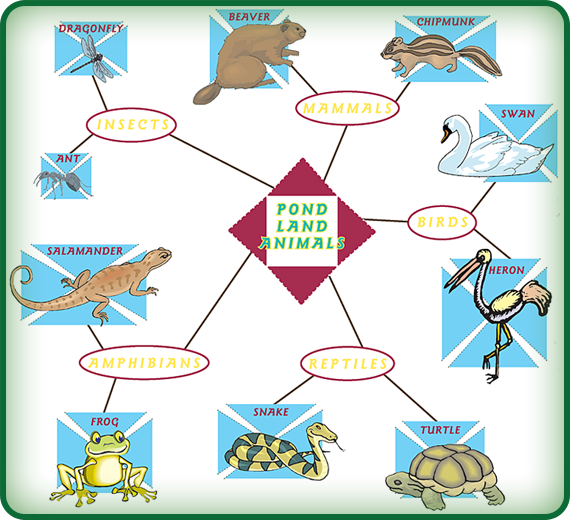

In [0]:
Image(filename='/Users/ksmith/Documents/Code/DS1/Unit4/DS-Unit-4-Sprint-4-Deep-Learning/downloads/animal pond/3. pkls4116_inline.png',width=600)

In [47]:
img_contains_frog(process_img_path('/content/downloads/animal pond/3. pkls4116_inline.png'))

[('n04243546', 'slot', 0.8712449), ('n04476259', 'tray', 0.04993588), ('n03908618', 'pencil_box', 0.023072386)]


0.0

In [48]:
img_contains_fish(process_img_path('/content/downloads/animal pond/3. pkls4116_inline.png'))

[('n04243546', 'slot', 0.8712449), ('n04476259', 'tray', 0.04993588), ('n03908618', 'pencil_box', 0.023072386)]


0.0

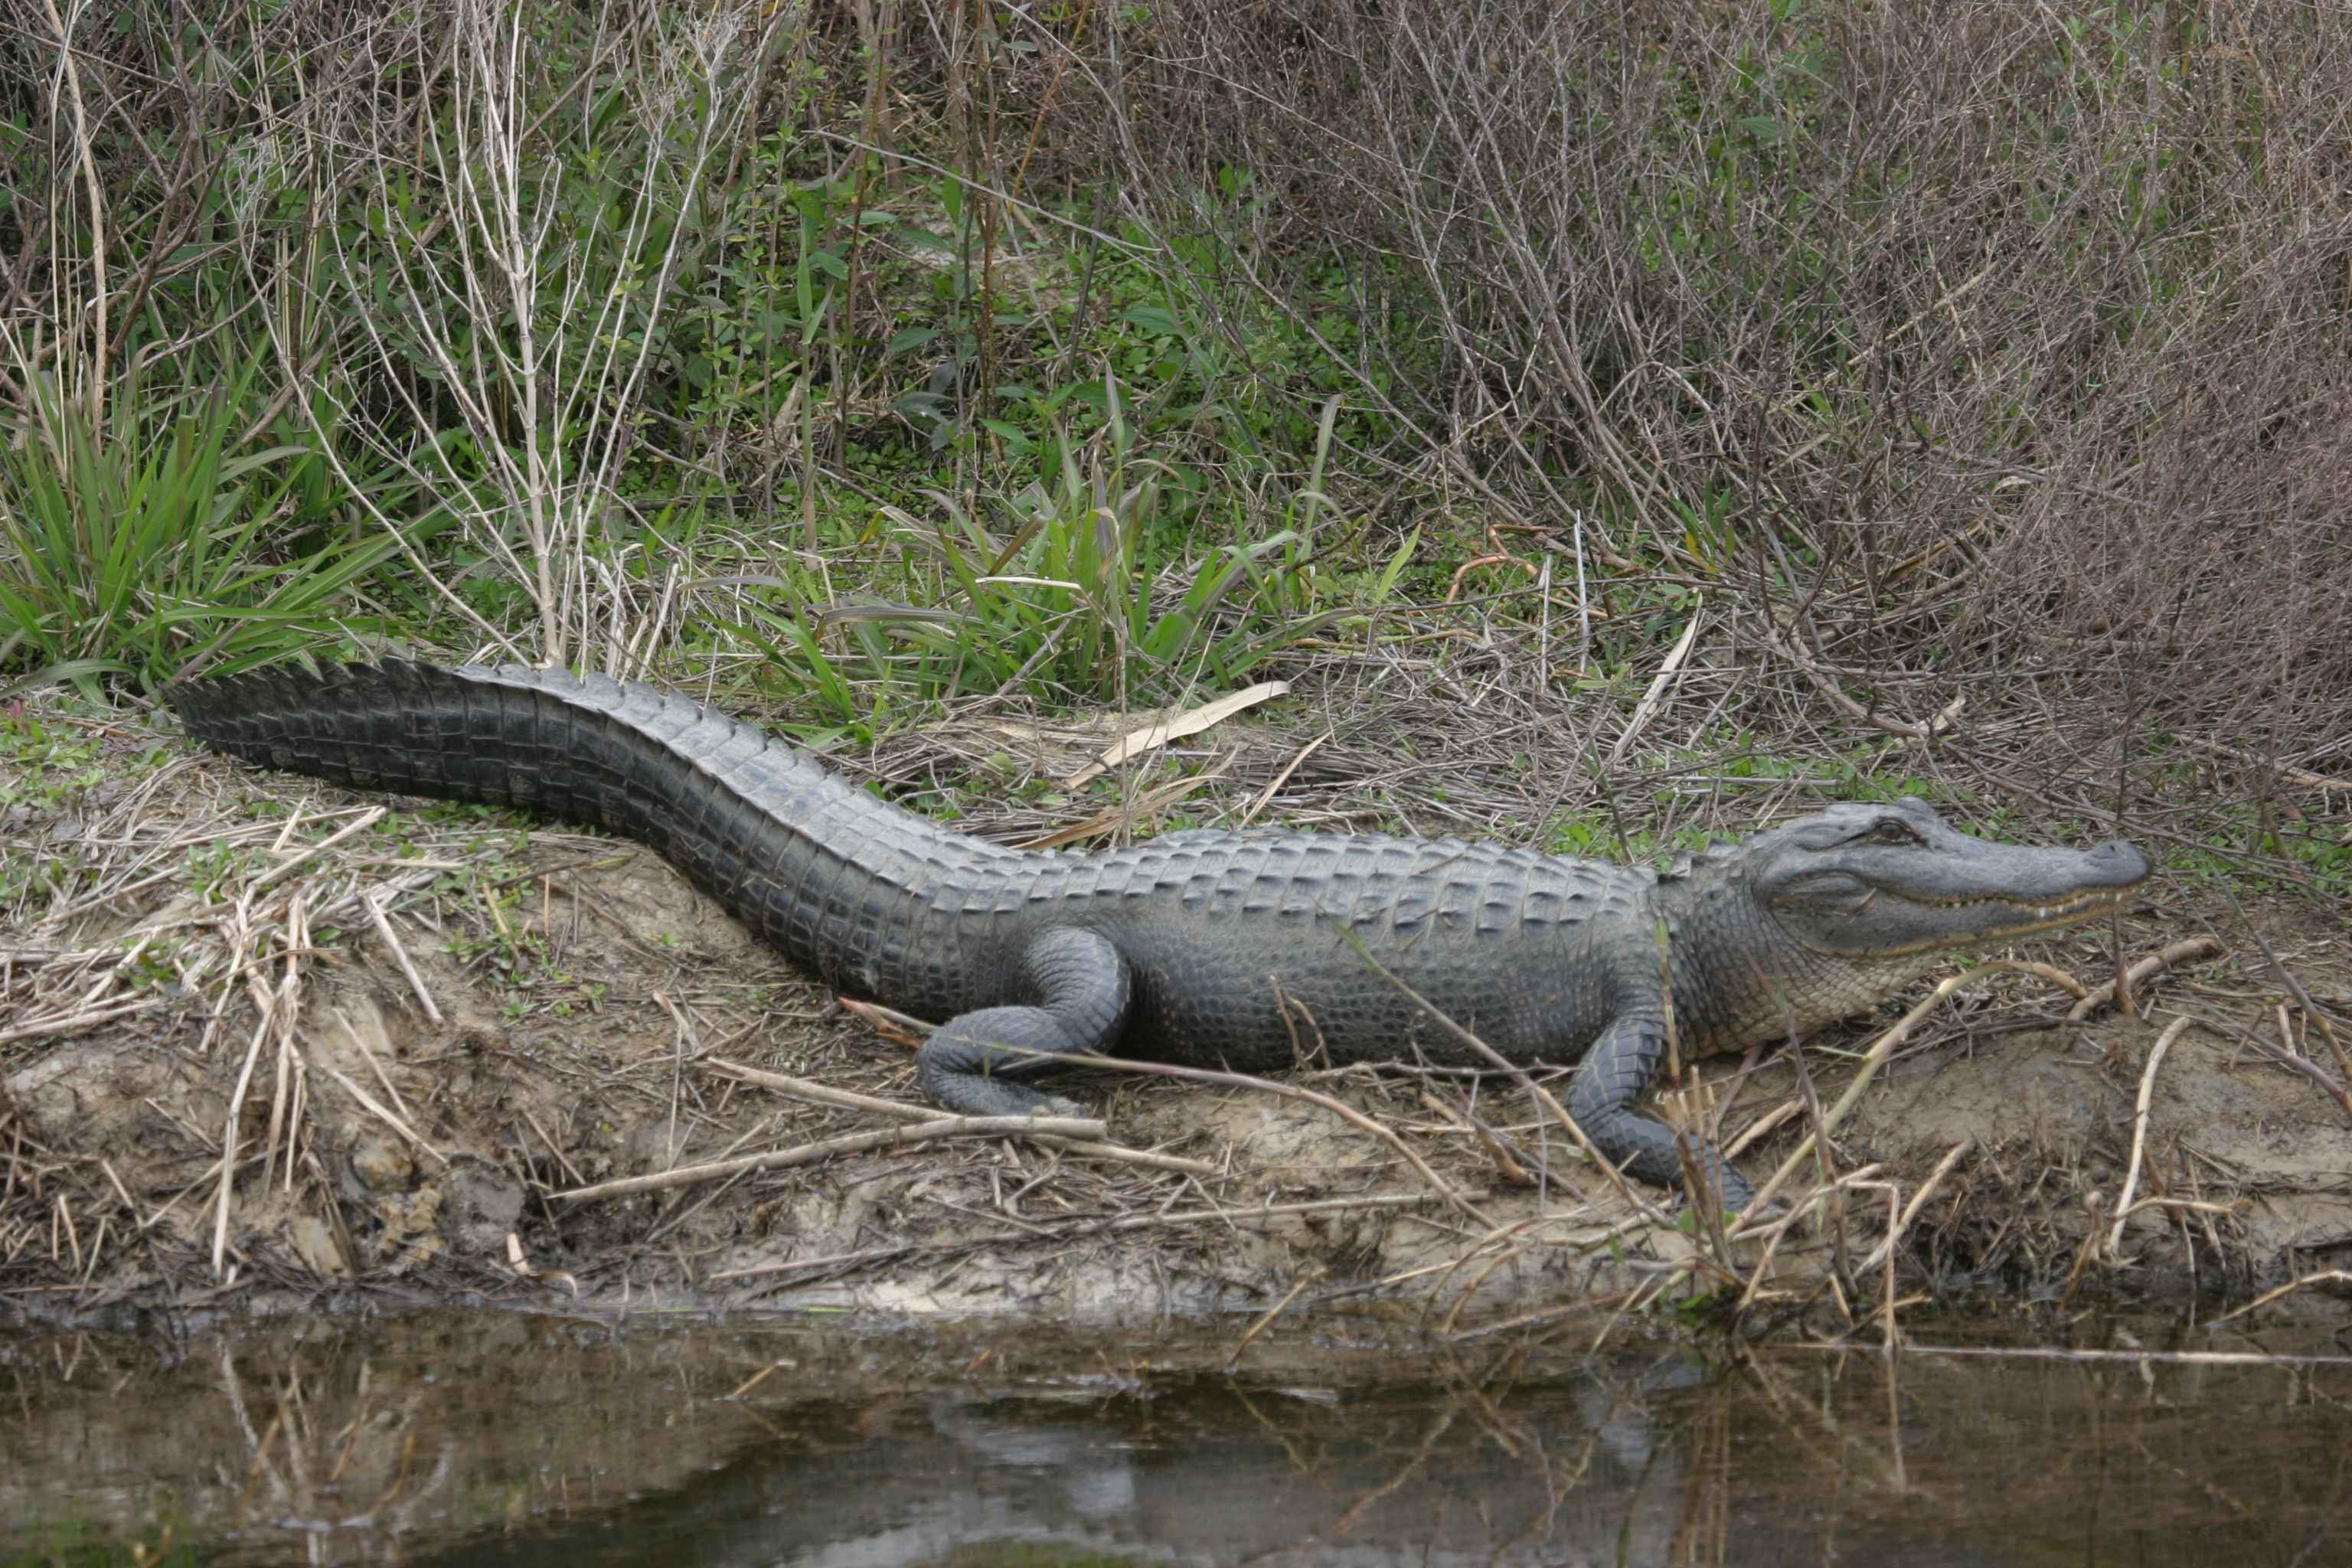

In [0]:
Image(filename='/Users/ksmith/Documents/Code/DS1/Unit4/DS-Unit-4-Sprint-4-Deep-Learning/downloads/animal pond/4. alligator-animal-on-pond.jpg',width=600)

In [49]:
img_contains_frog(process_img_path('/content/downloads/animal pond/5. alligator-animal-on-pond.jpg'))

[('n01698640', 'American_alligator', 0.96394104), ('n01697457', 'African_crocodile', 0.026759902), ('n01737021', 'water_snake', 0.005964664)]


0.0

In [50]:
img_contains_fish(process_img_path('/content/downloads/animal pond/5. alligator-animal-on-pond.jpg'))

[('n01698640', 'American_alligator', 0.96394104), ('n01697457', 'African_crocodile', 0.026759902), ('n01737021', 'water_snake', 0.005964664)]


0.0

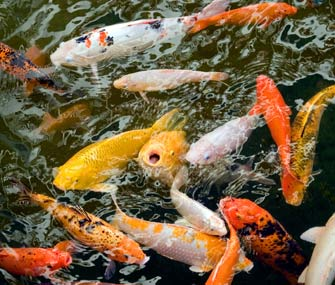

In [51]:
Image(filename='/content/downloads/animal pond/4. koi-pond-thinkstock-153560141-335sm61313.jpg',width=600)

In [52]:
img_contains_frog(process_img_path('/content/downloads/animal pond/4. koi-pond-thinkstock-153560141-335sm61313.jpg'))

[('n01443537', 'goldfish', 0.98815376), ('n09256479', 'coral_reef', 0.006681344), ('n12985857', 'coral_fungus', 0.00260608)]


0.0

In [53]:
img_contains_fish(process_img_path('/content/downloads/animal pond/4. koi-pond-thinkstock-153560141-335sm61313.jpg'))

[('n01443537', 'goldfish', 0.98815376), ('n09256479', 'coral_reef', 0.006681344), ('n12985857', 'coral_fungus', 0.00260608)]


0.98815376

## Part 3 - AutoML

Use [TPOT](https://github.com/EpistasisLab/tpot) to fit a predictive model for the King County housing data, with `price` as the target output variable.

In [1]:
!pip install tpot

    100% |████████████████████████████████| 81kB 6.7MB/s 
    100% |████████████████████████████████| 942kB 10.4MB/s 
  Stored in directory: /root/.cache/pip/wheels/3c/85/2b/2580190404636bfc63e8de3dff629c03bb795021e1983a6cc7
  Stored in directory: /root/.cache/pip/wheels/22/ea/bf/dc7c8a2262025a0ab5da9ef02282c198be88902791ca0c6658
Successfully built stopit deap


In [2]:
!pip install category_encoders

    100% |████████████████████████████████| 61kB 5.2MB/s 


In [3]:
from tpot import TPOTRegressor
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/ryanleeallred/datasets/master/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


As with previous questions, your goal is to run TPOT and successfully run and report error at the end.  Also, in the interest of time, feel free to choose small `generation=1` and `population_size=10` parameters so your pipeline runs efficiently and you are able to iterate and test.

*Hint* - you'll have to drop and/or type coerce at least a few variables to get things working. It's fine to err on the side of dropping to get things running, as long as you still get a valid model with reasonable predictive power.

In [0]:
import category_encoders as ce
from sklearn.model_selection import train_test_split

encoder = ce.OrdinalEncoder()

train_features = df.drop(['price','id'], axis=1)

X = encoder.fit_transform(train_features)
X = X.values

y = df['price'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.75, test_size=0.25)

In [56]:
%%time

tpot = TPOTRegressor(generations=1, population_size=10, verbosity=2)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))

Generation 1 - Current best internal CV score: -19595124795.91286

Best pipeline: RandomForestRegressor(OneHotEncoder(input_matrix, minimum_fraction=0.1, sparse=False, threshold=10), bootstrap=False, max_features=0.45, min_samples_leaf=11, min_samples_split=20, n_estimators=100)
-21240951567.371136
CPU times: user 5min 16s, sys: 27.3 s, total: 5min 43s
Wall time: 5min 16s


In [57]:
tpot.predict(X_test)

array([180165.19163871, 950682.88439664, 742990.7718282 , ...,
       611749.33576027, 440123.79217586, 590087.78159474])

In [58]:
y_test

array([220000., 767500., 595000., ..., 735000., 464000., 718000.])

## Part 4 - More...

Answer the following questions, with a target audience of a fellow Data Scientist:

- What do you consider your strongest area, as a Data Scientist?
- What area of Data Science would you most like to learn more about, and why?
- Where do you think Data Science will be in 5 years?

A few sentences per answer is fine - only elaborate if time allows.

### Answers

1. My strongest area would be understanding and initial analysis of the data. I have an eye for detail and I understand when data needs to be cleaned vs dropped completely. 

2. I would really like to learn more about Natural Language Processing. I think knowing how to do this would be really helpful in today's social network age. There are a lot of places to find written text in digital form and it would help businesses to predict many different things.

3. A lot of data science will likely be more automated (things like autoML and TPOT coming out more frequently) which will allow for more accurate predictions and more work placed on optimizing models rather than cleaning data.

Thank you for your hard work, and congratulations! You've learned a lot, and should proudly call yourself a Data Scientist.